In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from time import time

# to plot pretty histograms
import seaborn as sns
import pandas as pd

from sde.sde_learning_network import \
    (
        SDEIdentification,
        ModelBuilder,
        SDEApproximationNetwork,
    )

from sde.experiment_reports import \
(
    sample_data,
    plot_results_functions,
    generate_results,
    plot_results_1d,
    probability_density
)

%load_ext autoreload
%autoreload 2

In [2]:
# notebook parameters
random_seed = 1
step_size = 1e-2  # step size
n_pts = 10000        # number of points

n_layers = 2
n_dim_per_layer = 50

n_dimensions = 1

LEARNING_RATE = 1e-3
ACTIVATIONS = tf.nn.elu
VALIDATION_SPLIT = .1
BATCH_SIZE = 32
N_EPOCHS = 100

# only diagonal, but we are in 1D so it does not matter anyway
diffusivity_type = "diagonal"

tf.random.set_seed(random_seed)

In [3]:
# EXAMPLE 1
def true_potential(x):
    return (x**4-4*x**2+3*x)/2


def true_drift(x):
    return -(4*x**3 - 2*4*x+3)/2 # negative derivative of the potential


def true_diffusivity(x):
    return (1e-1*x+1)*0.5
    # return true_drift(x), true_diffusivity(x)


def true_drift_diffusivity(x, param=None):
    return true_drift(x), true_diffusivity(x)


rng = np.random.default_rng(random_seed)

xlim = [-2, 2]

x_data, y_data = sample_data(true_drift_diffusivity,
                             step_size=step_size, n_dimensions=n_dimensions,
                             low=xlim[0], high=xlim[1], n_pts=n_pts,
                             rng=rng, n_subsample=100)
x_data_test, y_data_test = sample_data(true_drift_diffusivity,
                                       step_size=step_size,
                                       n_dimensions=n_dimensions,
                                       low=xlim[0], high=xlim[1],
                                       n_pts=n_pts//10, rng=rng,
                                       n_subsample=100)
print('data shape', x_data.shape)

step_sizes = np.zeros((x_data.shape[0],)) + step_size

data shape (10000, 1)


In [4]:
# define the neural network model we will use for identification
encoder_euler = ModelBuilder.define_gaussian_process(
                                        n_input_dimensions=n_dimensions,
                                        n_output_dimensions=n_dimensions,
                                        n_layers=n_layers,
                                        n_dim_per_layer=n_dim_per_layer,
                                        name="Euler",
                                        diffusivity_type=diffusivity_type,
                                        activation=ACTIVATIONS)

encoder_milstein = ModelBuilder.define_gaussian_process(
                                        n_input_dimensions=n_dimensions,
                                        n_output_dimensions=n_dimensions,
                                        n_layers=n_layers,
                                        n_dim_per_layer=n_dim_per_layer,
                                        name="Milstein",
                                        diffusivity_type=diffusivity_type,
                                        activation=ACTIVATIONS)
encoder_euler.summary()

Model: "Euler_gaussian_process"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Euler_inputs (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 Euler_mean_hidden_0 (Dense)    (None, 50)           100         ['Euler_inputs[0][0]']           
                                                                                                  
 Euler_std_hidden_0 (Dense)     (None, 50)           100         ['Euler_inputs[0][0]']           
                                                                                                  
 Euler_mean_hidden_1 (Dense)    (None, 50)           2550        ['Euler_mean_hidden_0[0][0]']    
                                                                             

In [5]:
model_euler = SDEApproximationNetwork(sde_model=encoder_euler, method="euler")
model_euler.compile(optimizer=tf.keras.optimizers.Adamax())
sde_i_euler = SDEIdentification(model=model_euler)

hist_euler = sde_i_euler.train_model(x_data, y_data, step_size=step_sizes,
                                     validation_split=VALIDATION_SPLIT, n_epochs=N_EPOCHS, batch_size=BATCH_SIZE)

model_milstein = SDEApproximationNetwork(sde_model=encoder_milstein, method="milstein")
model_milstein.compile(optimizer=tf.keras.optimizers.Adamax())
sde_i_milstein = SDEIdentification(model=model_milstein)

hist_milstein = sde_i_milstein.train_model(x_data, y_data, step_size=step_sizes,
                                           validation_split=VALIDATION_SPLIT, n_epochs=N_EPOCHS, batch_size=BATCH_SIZE)

training for 100 epochs with 9000 data points, validating with 1000
The average loss for epoch 99 is -0.0035423513 training for 100 epochs with 9000 data points, validating with 1000
The average loss for epoch 99 is -0.0010335571 

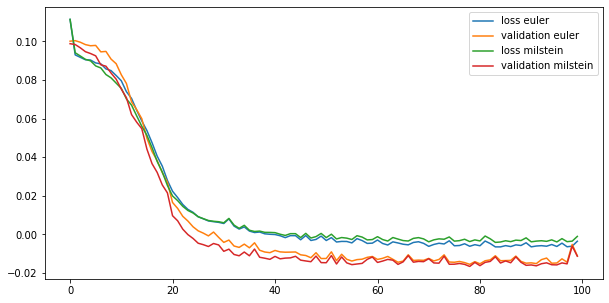

In [6]:
fig, hist_axes = plt.subplots(1, 1, figsize=(10, 5))
hist_axes.clear()
hist_axes.plot(hist_euler.history["loss"], label='loss euler')
hist_axes.plot(hist_euler.history["val_loss"], label='validation euler')
hist_axes.plot(hist_milstein.history["loss"], label='loss milstein')
hist_axes.plot(hist_milstein.history["val_loss"], label='validation milstein')
hist_axes.legend()

fig.savefig("figures/example3_milstein_vs_euler_losscurves.pdf")
fig.savefig("figures/example3_milstein_vs_euler_losscurves.png")

In [7]:
print(f"Training loss final, Euler: {hist_euler.history['loss'][-1]}")
print(f"Validation loss final, Euler: {hist_euler.history['val_loss'][-1]}")
print(f"Training loss final, Milstein: {hist_milstein.history['loss'][-1]}")
print(f"Validation loss final, Milstein: {hist_milstein.history['val_loss'][-1]}")

Training loss final, Euler: -0.003542351304999234
Validation loss final, Euler: -0.011131951486574844
Training loss final, Milstein: -0.0010335571450641409
Validation loss final, Milstein: -0.011298705304139262


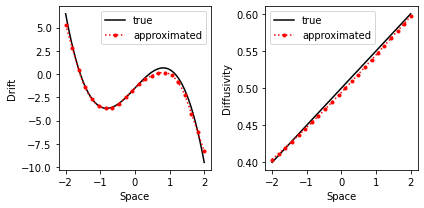

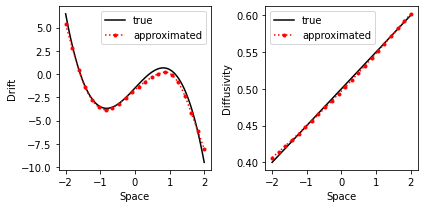

In [8]:
rng = np.random.default_rng(random_seed)

ax = plot_results_functions(sde_i_euler.drift_diffusivity, true_drift_diffusivity,
                            x_data, y_data, rng,
                            data_transform_network=None,
                            data_transform_true=None)

#plt.gcf().savefig("figures/example_1dcubic_functions.pdf")
#plt.gcf().savefig("figures/example_1dcubic_functions.png")
plt.gcf().tight_layout()

rng = np.random.default_rng(random_seed)

ax = plot_results_functions(sde_i_milstein.drift_diffusivity, true_drift_diffusivity,
                            x_data, y_data, rng,
                            data_transform_network=None,
                            data_transform_true=None)

#plt.gcf().savefig("figures/example_1dcubic_functions.pdf")
#plt.gcf().savefig("figures/example_1dcubic_functions.png")
plt.gcf().tight_layout()

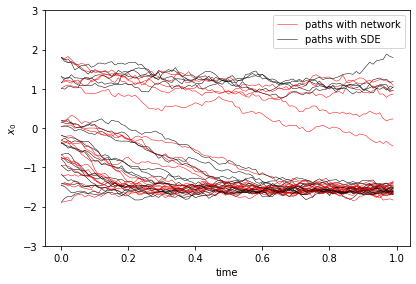

In [9]:
T_steps = 100
N_iterates = 20

rng = np.random.default_rng(random_seed)

time_steps, paths_network = \
    generate_results(sde_i_milstein.drift_diffusivity,
                     step_size, x_data, rng,
                     T_steps=T_steps, N_iterates=N_iterates);
time_steps, paths_true = \
    generate_results(true_drift_diffusivity,
                     step_size, x_data, rng,
                     T_steps=T_steps, N_iterates=N_iterates);

plot_results_1d(time_steps, paths_network, paths_true, plot_dim=0, linewidth=.5);
plt.gca().set_ylim([-3,3])
plt.gca().set_ylabel(r"$x_0$");

sampling network took 0.14191746711730957 seconds.
sampling sde took 0.15453290939331055 seconds.
sampling network took 0.12539410591125488 seconds.
sampling sde took 0.15741896629333496 seconds.
sampling network took 0.12539219856262207 seconds.
sampling sde took 0.1414022445678711 seconds.
sampling network took 0.1410236358642578 seconds.
sampling sde took 0.1410210132598877 seconds.
sampling network took 0.14090228080749512 seconds.
sampling sde took 0.14107823371887207 seconds.
sampling network took 0.13389968872070312 seconds.
sampling sde took 0.14852404594421387 seconds.
sampling network took 0.12539124488830566 seconds.
sampling sde took 0.14139699935913086 seconds.
sampling network took 0.14230895042419434 seconds.
sampling sde took 0.1439037322998047 seconds.
sampling network took 0.12178254127502441 seconds.
sampling sde took 0.15637993812561035 seconds.
sampling network took 0.12578296661376953 seconds.
sampling sde took 0.15670228004455566 seconds.
sampling network took 0.

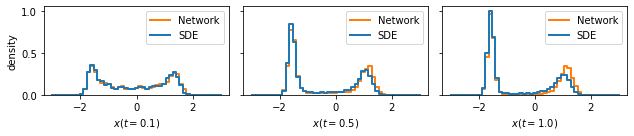

In [16]:
"""
Generate the probability density of all states at a particular time t.
"""


N_iterates = 500
n_initials = 10
t_ends = [0.1, 0.5, 1.0]
idx_ax = 0
rng = np.random.default_rng(random_seed)
tf.random.set_seed(random_seed)

fig, ax = plt.subplots(1, len(t_ends), figsize=(3 * len(t_ends), 2), sharey=True)

for t_end in t_ends:
    _pn = []
    _pt = []

    for k in range(n_initials):
        initial_condition = np.array([np.linspace(xlim[0], xlim[1], n_initials)[k]]).reshape(1, 1)

        def gen_results_n(step_size, T_steps, N_iterates, rng):
            """
            Wrapper function so that we do not need to pass all these parameters to "probability_density".
            """
            paths = sde_i_milstein.sample_path(initial_condition, step_size, T_steps, N_iterates)

            time_steps = [np.arange(T_steps) * step_size] * N_iterates
            return time_steps, paths


        def gen_results_t(step_size, T_steps, N_iterates, rng):
            """
            Wrapper function so that we do not need to pass all these parameters to "probability_density".
            """
            return generate_results(true_drift_diffusivity,
                                step_size, initial_condition,
                                rng, T_steps = T_steps, N_iterates=N_iterates)

        t0 = time()
        pn, time_steps_n, paths_n = probability_density(t=t_end, _generate_results=gen_results_n,
                                                        step_size=step_size, rng=rng, N_iterates=N_iterates)
        print(f"sampling network took {time()-t0} seconds.")

        t0 = time()
        pt, time_steps_t, paths_t = probability_density(t=t_end, _generate_results=gen_results_t,
                                                        step_size=step_size, rng=rng, N_iterates=N_iterates)
        print(f"sampling sde took {time()-t0} seconds.")

        _pn.append(pn)
        _pt.append(pt)

    _pn = np.row_stack(_pn)
    _pt = np.row_stack(_pt)

    n1 = pd.DataFrame(_pn[:, 0], columns=["network"])
    t1 = pd.DataFrame(_pt[:, 0], columns=["true"])

    bins = np.linspace(xlim[0]-1, xlim[1]+1, N_iterates * n_initials // 100)

    data = pd.DataFrame(np.column_stack([n1, t1]), columns=["Network", "SDE"])
    p = sns.histplot(data, ax=ax[idx_ax], linewidth=2, bins=bins, line_kws=dict(alpha=.3),
                 fill=False, stat="density", element="step", legend=False)
    ax[idx_ax].legend(labels=["Network", "SDE"], loc="upper right")

    ax[idx_ax].set_xlabel(r"$x(t="+str(t_end)+")$")
    if idx_ax == 0:
        ax[idx_ax].set_ylabel("density")
    idx_ax += 1

fig.tight_layout()

In [17]:
fig.savefig("figures/example7_1dcubic_approx_densities.pdf")
fig.savefig("figures/example7_1dcubic_approx_densities.png")